In [1]:
import os
if not os.path.exists('common.py'):
    print('trying to find project root directory by chaning to parent directory')
    os.chdir('..')
if os.path.exists('common.py'):
    print('all good')
else:
    print('could not find project root directory')

trying to find project root directory by chaning to parent directory
all good


In [2]:
import data
from sklearn.model_selection import train_test_split

x = data.x
y = data.y.filter(['sphere', 'worm', 'vesicle', 'other'], axis=1).replace(-1, 0)
vesicle = y['vesicle']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=0, stratify=y.other)
len(y_test), sum(y_test.other)

(30, 1)

In [3]:
from models import random_forest_pcc, random_forest_ind

random_forest_pcc.fit(x_train, y_train)
random_forest_ind.fit(x_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=200,
                                                       random_state=RandomState(MT19937) at 0x12A513A40))

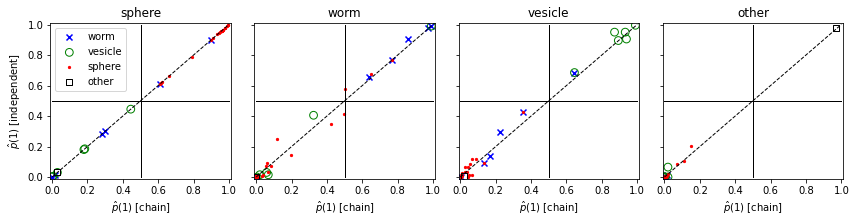

In [4]:
from matplotlib import pyplot as plt
from plotting import scatter_phases

fig, axs = plt.subplots(1, 4, figsize=(12, 3.2), tight_layout=True, sharey=True, sharex=True)

for i in range(4):
    axs[i].plot([0, 1], [0, 1], lw=1, ls='--', color='black')
    axs[i].plot([0, 1], [0.5, 0.5], lw=1, color='black')
    axs[i].plot([0.5, 0.5], [0, 1], lw=1, color='black')
    scatter_phases(y_test, random_forest_pcc.predict_proba(x_test)[:, i], random_forest_ind.predict_proba(x_test)[:, i], ax=axs[i])
    axs[i].set_xlabel(r'$\hat{p}(1)$ [chain]')
    axs[i].set_title(y_test.columns[i])

axs[0].set_ylabel(r'$\hat{p}(1)$ [independent]')
axs[2].set_xlim(-0.01, 1.01)
axs[2].set_ylim(-0.01, 1.01)
axs[0].legend()
plt.show()

In [5]:
# import numpy as np
# import pandas as pd
# from sklearn.base import clone
# from scipy.stats import entropy

# class ActiveLearningExperiment:

#     def __init__(self, est, x_train, x_test, y_train, y_test, k):
#         self.estimator = est
#         self.fits = []
#         self.x_train = [x_train]
#         self.x_test = [x_test]
#         self.y_train = [y_train]
#         self.y_test = [y_test]
#         self.k = k # how many points to request

#     def _augment_train(self, i):
#         self.x_train.append(pd.concat((self.x_train[-1], self.x_test[-1].iloc[i:i+1])))
#         self.y_train.append(pd.concat((self.y_train[-1] ,self.y_test[-1].iloc[i: i+1])))
#         self.x_test.append(self.x_test[-1].drop(self.x_test[-1].index[i]))
#         self.y_test.append(self.y_test[-1].drop(self.y_test[-1].index[i]))

#     def _fit(self):
#         print('fit with ', len(self.x_train[-1]), ' sample size')
#         est = clone(self.estimator, safe=False)
#         est.fit(self.x_train[-1], self.y_train[-1])
#         self.fits.append(est)

#     def run(self):
#         print('initial fit')
#         self._fit()
#         while len(self.fits)<self.k+1:
#             print('augmenting data')
#             H = entropy(self.fits[-1].predict_full_proba(self.x_test[-1]), axis=1)
#             max_entropy_idx = np.argmax(H)
#             print('point', max_entropy_idx, self.x_test[-1].iloc[max_entropy_idx]['conc'], self.x_test[-1].iloc[max_entropy_idx]['dp_core'])
#             self._augment_train(max_entropy_idx)
#             self._fit()


In [10]:
def plot_morphology_contour(name, xx1, xx2, probs, col, ax):
    # if probs.min()>0.5:
    #     print('all', name)
    if probs.max()<0.5:
        print('no', name)
    else:
        ax.contourf(xx1, xx2, probs.reshape(xx1.shape), levels=[0.5, 1], colors=col, alpha=0.2)
        ax.contour(xx1, xx2, probs.reshape(xx1.shape), levels=[0.5], colors=col)

def meshgrid_around_sample(x1, x2, resolution=100, rel_margin = 0.1):
    x1_width = x1.max()-x1.min()
    x2_width = x2.max()-x2.min()
    x1_min = x1.min()-rel_margin*x1_width
    x1_max = x1.max()+rel_margin*x1_width
    x2_min = x2.min()-rel_margin*x2_width
    x2_max = x2.max()+rel_margin*x2_width
    xx1 = np.linspace(x1_min, x1_max, resolution)
    xx2 = np.linspace(x2_min, x2_max, resolution)
    xx1, xx2 = np.meshgrid(xx1, xx2, indexing='xy')
    return xx1, xx2

def x_grid_data_around_sample(sample, x1_var='conc', x2_var='dp_core', resolution=100, rel_margin = 0.1):
    """
    Generates grid of model input points around sample, varying only
    two variables and setting the rest equal to values in first sample point.
    """
    x1 = sample[x1_var]
    x2 = sample[x2_var]
    xx1, xx2 = meshgrid_around_sample(x1, x2, rel_margin=0.1, resolution=resolution)
    prototype = sample.iloc[0]
    return xx1, xx2, data.x_grid_data(prototype, xx1, xx2)


# def plot_marginal_morphology_contours(est, sample_x, x1_var='conc', x2_var='dp_core', ax=None, resolution = 100):
#     ax = plt.gca() if ax is None else ax

#     # x1 = sample_x[x1_var]
#     # x2 = sample_x[x2_var]

#     # xx1, xx2 = meshgrid_around_sample(x1, x2, rel_margin=0.1, resolution=resolution)
#     # prototype = sample_x.iloc[0]
#     # grid_points = data.x_grid_data(prototype, xx1, xx2)

#     grid_points = x_grid_data_around_sample(sample_x, 'conc', 'dp_core')
#     print('predict grid')
#     yy_hat = est.predict_proba(grid_points)
#     # HH = entropy(yy_hat, axis=1).reshape(xx1.shape)
#     # axs[i//5, i%5].contourf(xx1, xx2, HH, levels=100, cmap='RdPu')

def plot_marginal_morphology_contours(xx1, xx2, yy_hat, ax=None):
    ax = plt.gca() if ax is None else ax
    plot_morphology_contour('sphere', xx1, xx2, yy_hat[:, 0], 'red', ax=ax)
    plot_morphology_contour('worm', xx1, xx2, yy_hat[:, 1], 'blue', ax=ax)
    plot_morphology_contour('vesicle', xx1, xx2, yy_hat[:, 2], 'green', ax=ax)

# i = 1
# plot_marginal_morphology_contours(exp.fits[i], exp.x_train[i][-i:], exp.y_train[i][-i:])

In [11]:
pd.set_option('display.max_columns', None)
query2 = (data.x.core_HPMA == 1) & (data.x.corona_CysMA == 1)
x[query2][['dp_core', 'conc', 'dp_corona', 'salt', 'ph', 'charged', 'temp']]
# sum(query2), sum(~query2)

,dp_core,conc,dp_corona,salt,ph,charged,temp
199,50,10.0,31,0.0,7.0,1,70
200,100,10.0,31,0.0,7.0,1,70
201,150,10.0,31,0.0,7.0,1,70
202,200,10.0,31,0.0,7.0,1,70
203,250,10.0,31,0.0,7.0,1,70
204,300,10.0,31,0.0,7.0,1,70
205,100,15.0,31,0.0,7.0,1,70
206,125,15.0,31,0.0,7.0,1,70
207,150,15.0,31,0.0,7.0,1,70
208,175,15.0,31,0.0,7.0,1,70


In [8]:
from modules.experiments import ActiveLearningExperiment

exp2 = ActiveLearningExperiment(random_forest_pcc, x[~query2], x[query2], y[~query2], y[query2], 12)
exp2.run()

initial fit
fit with  570  sample size
augmenting data
point 19 20.0 225.0
fit with  571  sample size
augmenting data
point 12 15.0 250.0
fit with  572  sample size
augmenting data
point 10 15.0 200.0
fit with  573  sample size
augmenting data
point 3 10.0 200.0
fit with  574  sample size
augmenting data
point 15 20.0 165.0
fit with  575  sample size
augmenting data
point 10 15.0 300.0
fit with  576  sample size
augmenting data
point 2 10.0 150.0
fit with  577  sample size
augmenting data
point 5 15.0 125.0
fit with  578  sample size
augmenting data
point 2 10.0 250.0
fit with  579  sample size
augmenting data
point 7 20.0 50.0
fit with  580  sample size
augmenting data
point 9 20.0 150.0
fit with  581  sample size
augmenting data
point 8 20.0 125.0
fit with  582  sample size


/Users/mbol0005/Repositories/PISA_ML/data.py:157: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([deepcopy(prototype) for _ in range(m*n)], ignore_index=True)


predict grid


/var/folders/zh/5y3qbnsx201fr8wp5tgnfq_dy0qrfx/T/ipykernel_52984/398183411.py:8: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, probs.reshape(xx1.shape), levels=[0.5], colors=col)


no worm
no vesicle
predict grid
predict grid
predict grid
predict grid


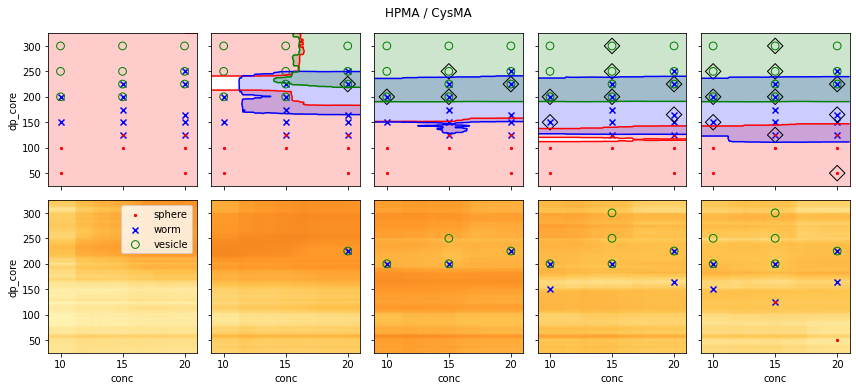

In [9]:
from plotting import SCATTER_STYLE_SPHERE, SCATTER_STYLE_WORM, SCATTER_STYLE_VESICLE

def plot_active_learning_experiment(exp, k = [0, 1, 4, 7, 10]):
    fig, axs = plt.subplots(2, 5, figsize=(12, 5.5), sharex=True, sharey=True, tight_layout=True)
    xx1, xx2, grid_points = x_grid_data_around_sample(exp.x_test[0], 'conc', 'dp_core')

    for j in range(len(k)):
        print('predict grid')
        yy_hat = exp.fits[k[j]].predict_proba(grid_points)
        plot_marginal_morphology_contours(xx1, xx2, yy_hat, ax=axs[0, j])
        scatter_phases(exp.y_test[0], exp.x_test[0]['conc'], exp.x_test[0]['dp_core'], ax=axs[0, j])

        HH = entropy(yy_hat, axis=1).reshape(xx1.shape)
        entropy_cp = axs[1, j].contourf(xx1, xx2, HH, levels=100, cmap='YlOrBr', vmin=0, vmax=2)
        # plt.colorbar(entropy_cp, ax=axs[1, j])

    for i in range(1, len(k)):
        axs[0, i].scatter(exp.x_train[k[i]][-k[i]:]['conc'], exp.x_train[k[i]][-k[i]:]['dp_core'], marker='D', facecolor='none', edgecolor='black', s=120)
        scatter_phases(exp.y_train[k[i]][-k[i]:], exp.x_train[k[i]][-k[i]:]['conc'], exp.x_train[k[i]][-k[i]:]['dp_core'], ax=axs[1, i])

    for j in range(len(k)):
        axs[1, j].set_xlabel('conc')

    axs[0, 0].set_ylabel('dp_core')
    axs[1, 0].set_ylabel('dp_core')

    axs[1, 0].scatter([], [], **SCATTER_STYLE_SPHERE)
    axs[1, 0].scatter([], [], **SCATTER_STYLE_WORM)
    axs[1, 0].scatter([], [], **SCATTER_STYLE_VESICLE)
    axs[1, 0].legend()
    return fig, axs

plot_active_learning_experiment(exp2)
plt.suptitle('HPMA / CysMA')
plt.show()

In [55]:
query = (data.x.core_HPMA == 1) & (data.x.corona_GMA == 1) & (data.x.dp_corona==78) & (data.x.salt==0) & (data.x.ph==7) & (data.x.charged==0) & (data.x.temp==70)
sum(query), sum(~query)

(44, 548)

In [65]:
query3 = (data.x.core_MEMA == 1) & (data.x.corona_GMA == 1)
x[query3][['dp_core', 'conc', 'dp_corona', 'salt', 'ph', 'charged', 'temp']]

,dp_core,conc,dp_corona,salt,ph,charged,temp
Entry no,,,,,,,
425,30,10.0,29,0.0,3.5,0,70
426,35,10.0,29,0.0,3.5,0,70
427,38,10.0,29,0.0,3.5,0,70
428,43,10.0,29,0.0,3.5,0,70
429,58,10.0,29,0.0,3.5,0,70
430,70,10.0,29,0.0,3.5,0,70
431,74,10.0,29,0.0,3.5,0,70
432,78,10.0,29,0.0,3.5,0,70
433,84,10.0,29,0.0,3.5,0,70


In [66]:
y[query3]

,sphere,worm,vesicle,other
Entry no,,,,
425,1,0,0,0
426,1,0,0,0
427,1,0,0,0
428,0,1,0,0
429,0,1,1,1
430,0,0,1,0
431,0,0,1,0
432,0,0,1,0
433,0,0,1,0


In [71]:
exp3 = ActiveLearningExperiment(random_forest_pcc, x[~query3], x[query3], y[~query3], y[query3], 16)
exp3.run()

initial fit
fit with  566  sample size
augmenting data
point 25 30.0 110.0
fit with  567  sample size
augmenting data
point 24 30.0 85.0
fit with  568  sample size
augmenting data
point 21 30.0 41.0
fit with  569  sample size
augmenting data
point 19 20.0 100.0
fit with  570  sample size
augmenting data
point 5 10.0 70.0
fit with  571  sample size
augmenting data
point 12 15.0 84.0
fit with  572  sample size
augmenting data
point 8 10.0 89.0
fit with  573  sample size
augmenting data
point 14 20.0 50.0
fit with  574  sample size
augmenting data
point 17 30.0 49.0
fit with  575  sample size
augmenting data
point 3 10.0 43.0
fit with  576  sample size
augmenting data
point 2 10.0 38.0
fit with  577  sample size
augmenting data
point 2 10.0 58.0
fit with  578  sample size
augmenting data
point 6 15.0 43.0
fit with  579  sample size
augmenting data
point 10 20.0 95.0
fit with  580  sample size
augmenting data
point 8 20.0 41.0
fit with  581  sample size
augmenting data
point 3 10.0 78.0
fi

/Users/mbol0005/Repositories/PISA_ML/data1.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([deepcopy(prototype) for _ in range(m*n)], ignore_index=True)


predict grid
no vesicle
predict grid
no worm
predict grid
predict grid
predict grid


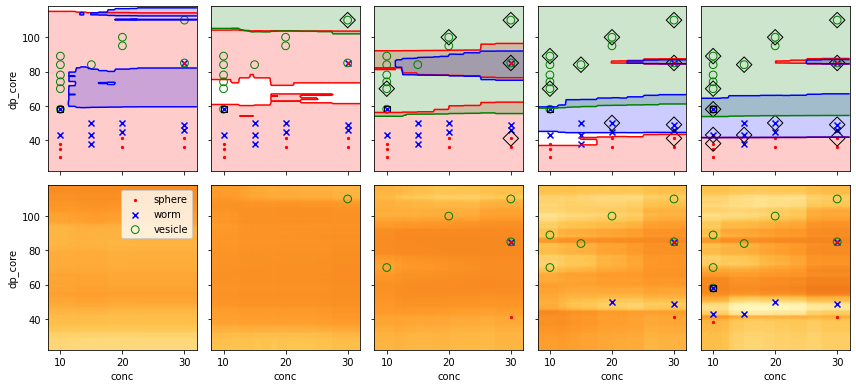

In [72]:
plot_active_learning_experiment(exp3, [0, 1, 5, 9, 13])
plt.show()

In [59]:
x_train, x_test, y_train, y_test = x[~query], x[query], y[~query], y[query]
exp = ActiveLearningExperiment(random_forest_pcc, x_train, x_test, y_train, y_test, 14)
exp.run()

initial fit
fit with  548  sample size
augmenting data
point 37 25.0 225.0
fit with  549  sample size
augmenting data
point 37 25.0 250.0
fit with  550  sample size
augmenting data
point 17 15.0 275.0
fit with  551  sample size
augmenting data
point 4 10.0 250.0
fit with  552  sample size
augmenting data
point 35 25.0 275.0
fit with  553  sample size
augmenting data
point 35 25.0 300.0
fit with  554  sample size
augmenting data
point 10 13.0 300.0
fit with  555  sample size
augmenting data
point 24 17.0 350.0
fit with  556  sample size
augmenting data
point 21 17.0 250.0
fit with  557  sample size
augmenting data
point 10 13.0 350.0
fit with  558  sample size
augmenting data
point 8 13.0 250.0
fit with  559  sample size
augmenting data
point 32 25.0 500.0
fit with  560  sample size
augmenting data
point 20 17.0 300.0
fit with  561  sample size
augmenting data
point 3 10.0 225.0
fit with  562  sample size


/Users/mbol0005/Repositories/PISA_ML/data1.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([deepcopy(prototype) for _ in range(m*n)], ignore_index=True)


predict grid


/var/folders/zh/5y3qbnsx201fr8wp5tgnfq_dy0qrfx/T/ipykernel_14795/398183411.py:8: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, probs.reshape(xx1.shape), levels=[0.5], colors=col)


no worm
no vesicle
predict grid
no vesicle
predict grid
predict grid
predict grid


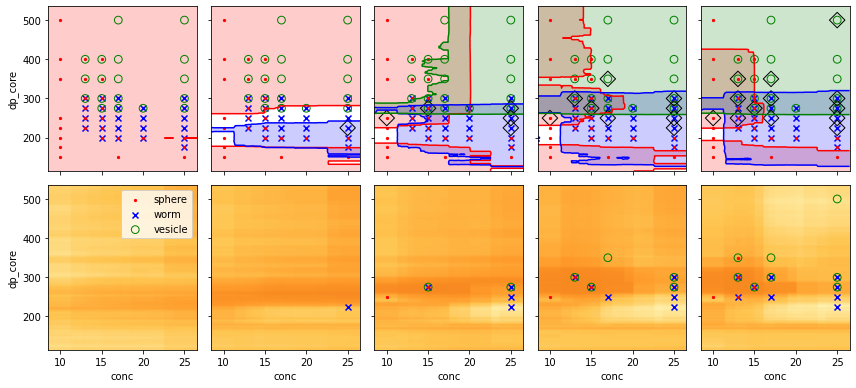

In [60]:
plot_active_learning_experiment(exp, [0, 1, 5, 9, 13])
plt.show()

In [6]:
x_train, x_test, y_train, y_test = x[~query], x[query], y[~query], y[query]

# random_forest_pcc.fit(x_train, y_train)

In [60]:
import numpy as np

xx1 = np.linspace(6, 28, 200)
xx2 = np.linspace(120, 530, 200)
xx1, xx2 = np.meshgrid(xx1, xx2, indexing='xy')

prototype = x_test.iloc[0]
prototype
grid_points = data.x_grid_data(prototype, xx1, xx2)

yy_hat = random_forest_pcc.predict_proba(grid_points)


/Users/mbol0005/Repositories/PISA_ML/data1.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([deepcopy(prototype) for _ in range(m*n)], ignore_index=True)


In [11]:
from scipy.stats import entropy

y_hat_full = random_forest_pcc.predict_full_proba(x_test)
H = entropy(y_hat_full, axis=1)

/var/folders/zh/5y3qbnsx201fr8wp5tgnfq_dy0qrfx/T/ipykernel_25834/1163531861.py:2: UserWarning: No contour levels were found within the data range.
  plt.contour(xx1, xx2, yy_hat_vesicle, levels=[0.5], color='black')
/var/folders/zh/5y3qbnsx201fr8wp5tgnfq_dy0qrfx/T/ipykernel_25834/1163531861.py:2: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(xx1, xx2, yy_hat_vesicle, levels=[0.5], color='black')


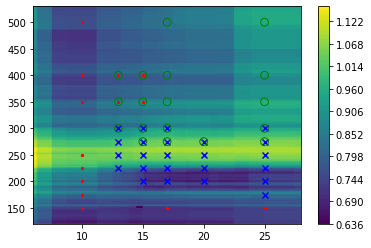

In [61]:
cp = plt.contourf(xx1, xx2, entropy(yy_hat, axis=1).reshape(xx1.shape), levels=100)
plt.contour(xx1, xx2, yy_hat_vesicle, levels=[0.5], color='black')
scatter_phases(y_test, x_test['conc'], x_test['dp_core'])
plt.colorbar(cp)

In [52]:
x_test.index[np.argmax(H)]

535

In [ ]:
query = (data.x.core_HPMA == 1) & (data.x.corona_GMA == 1) & (data.x.dp_corona==78) & (data.x.salt==0) & (data.x.ph==7) & (data.x.charged==0) & (data.x.temp==70)
sum(query), sum(~query)

In [82]:
query3 = (data.x.core_BzMA == 1) & (data.x.corona_GMA == 1)
x[query3][['dp_core', 'conc', 'dp_corona', 'salt', 'ph', 'charged', 'temp']]

,dp_core,conc,dp_corona,salt,ph,charged,temp
Entry no,,,,,,,
556,50,10.0,51,0.0,7.0,0,70
557,75,10.0,51,0.0,7.0,0,70
558,100,10.0,51,0.0,7.0,0,70
559,125,10.0,51,0.0,7.0,0,70
560,150,10.0,51,0.0,7.0,0,70
561,175,10.0,51,0.0,7.0,0,70
562,200,10.0,51,0.0,7.0,0,70
563,250,10.0,51,0.0,7.0,0,70
564,300,10.0,51,0.0,7.0,0,70


In [95]:
query4 = (data.x.core_GlyMA == 1) & (data.x.corona_GMA == 1)
x[query4][['dp_core', 'conc', 'dp_corona', 'salt', 'ph', 'charged', 'temp']]

,dp_core,conc,dp_corona,salt,ph,charged,temp
Entry no,,,,,,,
312,100,10.0,45,0.0,5.20,0,70
313,100,10.0,45,0.0,7.10,0,70
314,100,10.0,45,0.0,4.50,0,40
315,100,10.0,45,0.0,7.20,0,40
316,100,10.0,45,0.0,4.20,0,50
317,100,10.0,45,0.0,7.10,0,50
318,300,10.0,45,0.0,7.00,0,50
319,400,10.0,45,0.0,7.00,0,50
320,100,10.0,45,0.0,3.00,0,30


In [96]:
y[query3]

,sphere,worm,vesicle,other
Entry no,,,,
312,1,0,0,0
313,1,0,0,0
314,1,0,0,0
315,1,0,0,0
316,1,0,0,0
317,1,0,0,0
318,0,0,0,0
319,0,0,0,0
320,1,0,0,0


In [83]:
exp3 = ActiveLearningExperiment(random_forest_pcc, x[~query3], x[query3], y[~query3], y[query3], 12)
exp3.run()

initial fit
fit with  576  sample size
augmenting data
point 4 10.0 150.0
fit with  577  sample size
augmenting data
point 12 30.0 250.0
fit with  578  sample size
augmenting data
point 3 10.0 125.0
fit with  579  sample size
augmenting data
point 2 10.0 100.0
fit with  580  sample size
augmenting data
point 2 10.0 175.0
fit with  581  sample size
augmenting data
point 0 10.0 50.0
fit with  582  sample size
augmenting data
point 8 40.0 250.0
fit with  583  sample size
augmenting data
point 1 10.0 200.0
fit with  584  sample size
augmenting data
point 0 10.0 75.0
fit with  585  sample size
augmenting data
point 4 10.0 1000.0
fit with  586  sample size
augmenting data
point 3 10.0 500.0
fit with  587  sample size
augmenting data
point 4 50.0 250.0
fit with  588  sample size


generate grid


/Users/mbol0005/Repositories/PISA_ML/data1.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([deepcopy(prototype) for _ in range(m*n)], ignore_index=True)


predict grid
all sphere
no worm
no vesicle


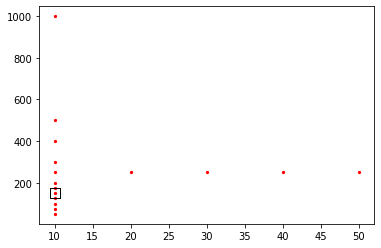

In [84]:
i = 1
plot_marginal_morphology_contours(exp3.fits[i], exp3.x_test[0], exp3.y_test[0])
plt.scatter(exp3.x_train[i][-i:]['conc'], exp3.x_train[i][-i:]['dp_core'], marker='s', facecolor='none', edgecolor='black', s=100)

In [97]:
exp4 = ActiveLearningExperiment(random_forest_pcc, x[~query4], x[query4], y[~query4], y[query4], 12)
exp4.run()

initial fit
fit with  577  sample size
augmenting data
point 14 15.0 60.0
fit with  578  sample size
augmenting data
point 8 10.0 100.0
fit with  579  sample size
augmenting data
point 12 15.0 55.0
fit with  580  sample size
augmenting data
point 8 15.0 25.0
fit with  581  sample size
augmenting data
point 8 15.0 40.0
fit with  582  sample size
augmenting data
point 4 10.0 100.0
fit with  583  sample size
augmenting data
point 5 10.0 300.0
fit with  584  sample size
augmenting data
point 7 15.0 50.0
fit with  585  sample size
augmenting data
point 3 10.0 100.0
fit with  586  sample size
augmenting data
point 5 15.0 45.0
fit with  587  sample size
augmenting data
point 4 10.0 400.0
fit with  588  sample size
augmenting data
point 1 10.0 100.0
fit with  589  sample size


generate grid


/Users/mbol0005/Repositories/PISA_ML/data1.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([deepcopy(prototype) for _ in range(m*n)], ignore_index=True)


predict grid


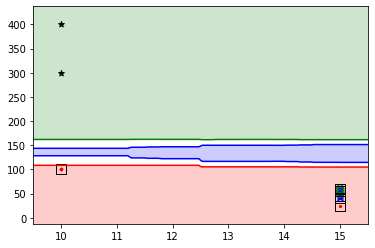

In [99]:
i = 6
plot_marginal_morphology_contours(exp4.fits[i], exp4.x_test[0], exp4.y_test[0])
plt.scatter(exp4.x_train[i][-i:]['conc'], exp4.x_train[i][-i:]['dp_core'], marker='s', facecolor='none', edgecolor='black', s=100)

/Users/mbol0005/Repositories/PISA_ML/data1.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([deepcopy(prototype) for _ in range(m*n)], ignore_index=True)


initial fit without condition
predict grid
all sphere
no worm
no vesicle
agumenting training data
point 37 25.0 225.0
refit
predict grid
no vesicle
agumenting training data
point 37 25.0 250.0
refit
predict grid
no vesicle
agumenting training data
point 17 15.0 275.0
refit
predict grid
agumenting training data
point 4 10.0 250.0
refit
predict grid
agumenting training data
point 35 25.0 275.0
refit
predict grid
agumenting training data
point 35 25.0 300.0
refit
predict grid
agumenting training data
point 10 13.0 300.0
refit
predict grid
agumenting training data
point 24 17.0 350.0
refit
predict grid
agumenting training data
point 21 17.0 250.0
refit
predict grid
agumenting training data
point 10 13.0 350.0
refit
predict grid
agumenting training data
point 8 13.0 250.0
refit
predict grid
agumenting training data
point 32 25.0 500.0
refit
predict grid
agumenting training data
point 20 17.0 300.0
refit
predict grid
agumenting training data
point 3 10.0 225.0
refit
predict grid
agumenting t

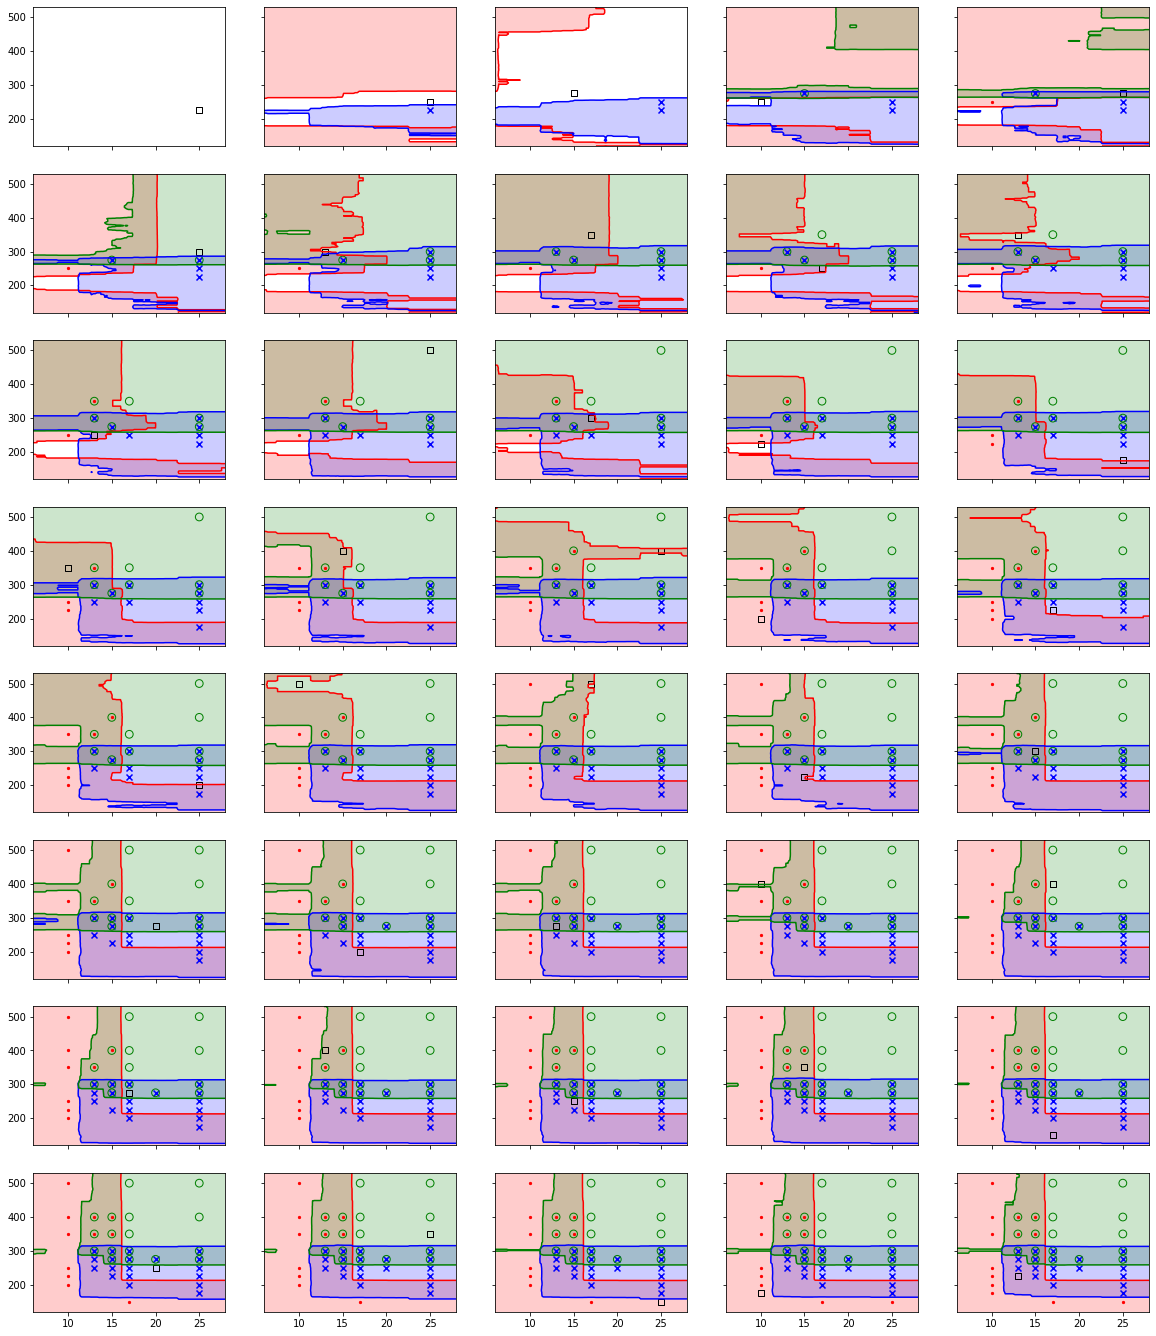

In [56]:
import pandas as pd
import numpy as np

resolution = 100

xx1 = np.linspace(6, 28, resolution)
xx2 = np.linspace(120, 530, resolution)
xx1, xx2 = np.meshgrid(xx1, xx2, indexing='xy')

prototype = x_test.iloc[0]
prototype
grid_points = data.x_grid_data(prototype, xx1, xx2)

def augment(i, x_train, x_test, y_train, y_test):
    _x_test, _y_test = x_test.drop(x_test.index[i]),  y_test.drop(y_test.index[i])
    _x_train, _y_train = pd.concat((x_train, x_test.iloc[i:i+1])), pd.concat((y_train ,y_test.iloc[i: i+1]))
    return _x_train, _x_test, _y_train, _y_test

x_train, x_test, y_train, y_test = x[~query], x[query], y[~query], y[query]
print('initial fit without condition')
random_forest_pcc.fit(x_train, y_train)

fig, axs = plt.subplots(8, 5, figsize=(20, 24), sharey=True, sharex=True)

def plot_morphology_contour(name, probs, col, ax):
    if probs.min()>0.5:
        print('all', name)
    elif probs.max()<0.5:
        print('no', name)
    else:
        ax.contourf(xx1, xx2, probs.reshape(xx1.shape), levels=[0.5, 1], colors=col, alpha=0.2)
        ax.contour(xx1, xx2, probs.reshape(xx1.shape), levels=[0.5], colors=col)
        # axs[i].contour(xx1, xx2, probs.reshape(xx1.shape), levels=[0.55], linestyles='--', linewidths=1, colors=col)

for i in range(40):
    print('predict grid')
    yy_hat = random_forest_pcc.predict_proba(grid_points)
    # HH = entropy(yy_hat, axis=1).reshape(xx1.shape)
    # axs[i//5, i%5].contourf(xx1, xx2, HH, levels=100, cmap='RdPu')

    plot_morphology_contour('sphere', yy_hat[:, 0], 'red', axs[i//5, i%5])
    plot_morphology_contour('worm', yy_hat[:, 1], 'blue', axs[i//5, i%5])
    plot_morphology_contour('vesicle', yy_hat[:, 2], 'green', axs[i//5, i%5])
    # yy_hat_worm = yy_hat[:, 1]
    # yy_hat_vesicle = yy_hat[:, 2]
    # yy_hat_other = yy_hat[:, 3]
    # scatter_phases(y_test, x_test['conc'], x_test['dp_core'], ax=axs[i])
    scatter_phases(y_train[len(y_train)-i:], x_train[len(y_train)-i:]['conc'], x_train[len(y_train)-i:]['dp_core'], ax=axs[i//5, i%5])

    print('agumenting training data')
    H = entropy(random_forest_pcc.predict_full_proba(x_test), axis=1)
    max_entropy_idx = np.argmax(H)
    axs[i//5, i%5].scatter(x_test.iloc[max_entropy_idx]['conc'], x_test.iloc[max_entropy_idx]['dp_core'], marker='s', facecolor='none', edgecolor='black')
    print('point', max_entropy_idx, x_test.iloc[max_entropy_idx]['conc'], x_test.iloc[max_entropy_idx]['dp_core'])
    x_train, x_test, y_train, y_test = augment(max_entropy_idx, x_train, x_test, y_train, y_test)
    print('refit')
    random_forest_pcc.fit(x_train, y_train)

plt.show()